# Итоговый проект по курсу "Машинное обучение в бизнесе". <a class='anchor' id='begin'>

## Содержание
* [Итоговый проект по курсу "Машинное обучение в бизнесе"](#begin) 
    * [Задание](#task)
    * [Загрузка библиотек и PATHS](#load_help)
    * [Загрузка данных](#load_data)
    * [1. Подготовка данных](#data_preparation)
    * [2. Моделирование](#modeling)
    * [3. Оценка](#evaluation)

## Задание <a class='anchor' id='task'>

1. Скачать датасет из Интернета
2. Придумать задачу по классификации или регрессии
3. Обучить модель
4. Оценить модель
5. Создать ноутбук с сервером
6. Создать ноутбук клиента
7. Сделать предсказание с помощью клиент-сервера.

В рамках задания был скачан датасет с автомобилями. По данному датасету была поставлена задача предсказания цены автомобиля.

## Загрузка библиотек и PATHS <a class='anchor' id='load_help'>

In [1]:
import pandas as pd
import numpy as np
import dill
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
RAW_DATASET_PATH = 'data/raw/car_price_prediction.csv'
PREPARED_DATASET_PATH = 'data/prepared/car_price_prediction_prepared.csv'
SPLIT_DATASET_DIR = 'model/dataset/'
MODEL_PATH = 'model/GBR_pipeline.dill'
TRAIN_PREDICTIONS_PATH = 'predictions/train_predictions.csv'
TEST_PREDICTIONS_PATH = 'predictions/test_predictions.csv'

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """       
    """
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    print()
    print("Test MSE:\t" + str(round(mean_squared_error(test_true_values, test_pred_values), 3)))
    print("Test MAE:\t" + str(round(mean_absolute_error(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## Загрузка данных <a class='anchor' id='load_data'>

Признаки:

1. ID - идентификатор
2. Price - цена
3. Levy - топливный сбор
4. Manufacturer - производитель
5. Model - название модели
6. Prod. year - год выпуска
7. Category - категория автомобиля ('Jeep', 'Hatchback', 'Sedan', 'Microbus', 'Goods wagon', 'Universal', 'Coupe', 'Minivan', 'Cabriolet', 'Limousine', 'Pickup')
8. Leather interior - кожаный салон
9. Fuel type - топливная система ('Hybrid', 'Petrol', 'Diesel', 'CNG', 'Plug-in Hybrid', 'LPG', 'Hydrogen')
10. Engine volume - объем двигателя
11. Mileage - пробег
11. Cylinders - количетсво цилиндров в двигателе
12. Gear box type - тип коробки переключения передач ('Automatic', 'Tiptronic', 'Variator', 'Manual')
13. Drive wheels - привод ('4x4', 'Front', 'Rear')
14. Doors - количество дверей ('04-May', '02-Mar', '>5')
15. Wheel - праворульная или леворульная машина ('Left wheel', 'Right-hand drive')
16. Color - цвет
17. Airbags - количество подушек безопасности

In [4]:
df = pd.read_csv(RAW_DATASET_PATH)
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


## 1. Подготовка данных <a class='anchor' id='data_preparation'>

### Преобразование формата 

Избавимся от пробелов в названиях признаков

In [5]:
df.rename(columns={'Engine volume': 'Engine_volume'}, inplace=True)
df.rename(columns={'Prod. year': 'Prod_year'}, inplace=True)
df.rename(columns={'Leather interior': 'Leather_interior'}, inplace=True)
df.rename(columns={'Fuel type': 'Fuel_type'}, inplace=True)
df.rename(columns={'Gear box type': 'Gear_box_type'}, inplace=True)
df.rename(columns={'Drive wheels': 'Drive_wheels'}, inplace=True)

In [6]:
df.head(2)

,ID,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8


В признаке Engine_volume иногда встречается приписка Turbo. Это означает, что двигатель имеет турбонадув, в теории эта информация может повлиять на цену, поэтому сохраним ее в отдельный столбец 'Turbo'. 

In [7]:
df['Turbo'] = df['Engine_volume'].str.contains("Turbo")

In [8]:
df['Turbo'].value_counts()

False    17306
True      1931
Name: Turbo, dtype: int64

И почистим сам признак Engine_volume от Turbo

In [9]:
for i in df['Engine_volume']:
    if i.endswith("Turbo"):
        df.loc[df['Engine_volume'] == i, 'Engine_volume'] = i[:-6]
    
df['Engine_volume'] = pd.to_numeric(df['Engine_volume'])

Убираем приписку km у призника Mileage

In [10]:
df['Mileage'] = df['Mileage'].str[:-3]
df['Mileage'] = pd.to_numeric(df['Mileage'])

### Анализ данных

Проверим пропуски

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod_year         19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather_interior  19237 non-null  object 
 8   Fuel_type         19237 non-null  object 
 9   Engine_volume     19237 non-null  float64
 10  Mileage           19237 non-null  int64  
 11  Cylinders         19237 non-null  float64
 12  Gear_box_type     19237 non-null  object 
 13  Drive_wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

Пропусков не обнаружено. Поделим признаки на группы:

In [12]:
num_features = ['Levy', 'Prod_year', 'Engine_volume', 'Mileage', 'Cylinders', 'Airbags']
cat_features = ['Manufacturer', 'Model', "Category", 'Fuel_type', 'Gear_box_type', 'Drive_wheels', 'Doors', 'Color']
bin_features = ['Leather_interior', 'Wheel', 'Turbo']
target = ['Price']

**Целевой признак**

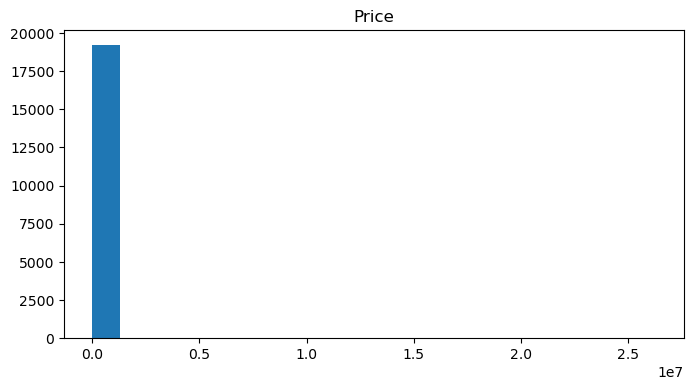

In [13]:
target_df = df[target]
target_df.hist(figsize=(8,4), bins=20, grid=False)
plt.show()

In [14]:
target_df.describe()

,Price
count,1.923700e+04
mean,1.855593e+04
std,1.905813e+05
min,1.000000e+00
25%,5.331000e+03
50%,1.317200e+04
75%,2.207500e+04
max,2.630750e+07


In [15]:
target_df[target_df > 310000].value_counts()

Price     
627220.0      1
872946.0      1
26307500.0    1
dtype: int64

Видим, что есть выбросы

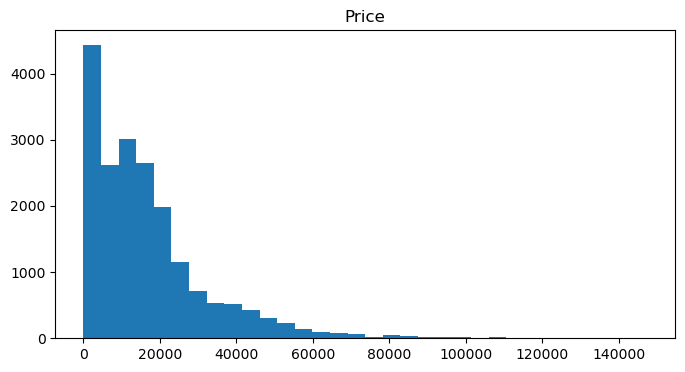

In [16]:
target_df = df[df[target] < 150000][target]
target_df.hist(figsize=(8,4), bins=32, grid=False)
plt.show()

**Вещественные признаки**

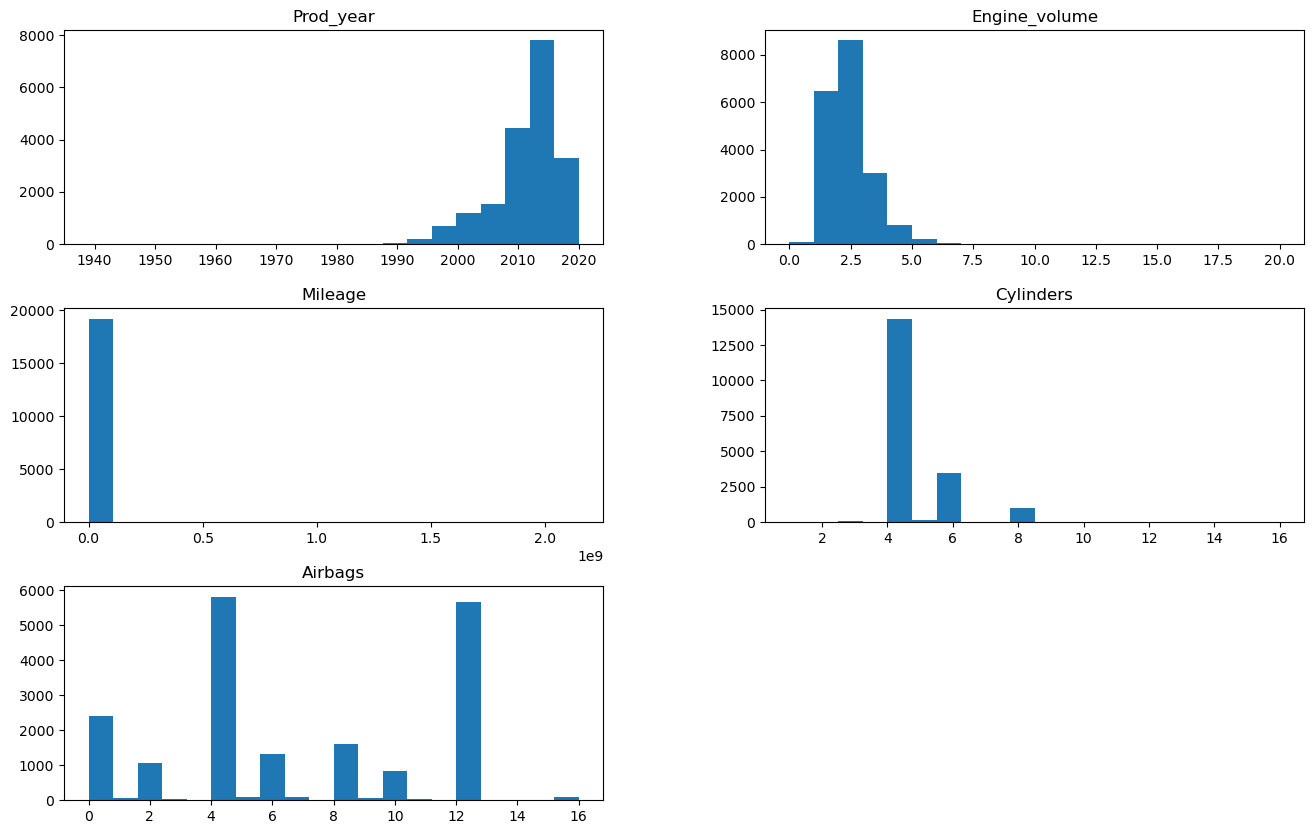

In [17]:
dftr_num_features = df[num_features]
dftr_num_features.hist(figsize=(16,10), bins=20, grid=False)
plt.show()

Видим, что есть выбросы

In [18]:
df['Cylinders'].value_counts()

4.0     14367
6.0      3462
8.0       991
5.0       169
3.0       107
2.0        42
1.0        38
12.0       38
10.0       12
16.0        5
7.0         4
9.0         1
14.0        1
Name: Cylinders, dtype: int64

In [19]:
df[df['Cylinders'] > 12]

,ID,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Turbo
456,45773579,11604,993,OPEL,Astra,2006,Goods wagon,No,Diesel,1.3,27000,16.0,Manual,Front,04-May,Left wheel,Black,8,True
1917,45768286,7000,-,HONDA,Fit Aria,2003,Hatchback,No,Petrol,1.5,140203,16.0,Automatic,Front,04-May,Right-hand drive,Silver,2,True
6863,45802046,21953,-,HYUNDAI,Elantra,2016,Sedan,Yes,Petrol,1.8,69000,16.0,Automatic,Front,04-May,Left wheel,Silver,16,False
8358,45797531,15681,966,CHEVROLET,Lacetti,2009,Sedan,Yes,Diesel,2.0,6500,14.0,Automatic,Front,04-May,Left wheel,White,8,False
12550,45770557,39829,-,BMW,X6,2009,Jeep,Yes,Petrol,3.5,152000,16.0,Tiptronic,4x4,04-May,Left wheel,Grey,16,True
16487,45772894,7213,-,OPEL,Combo,2001,Goods wagon,No,Diesel,1.7,242701,16.0,Manual,Front,02-Mar,Left wheel,Blue,2,True


In [20]:
df[df['Engine_volume'] > 8]

,ID,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Turbo
2357,45803214,10036,5603,HYUNDAI,Sonata,2014,Sedan,Yes,LPG,20.0,333686,4.0,Automatic,Front,04-May,Left wheel,Silver,4,False
17777,45732659,10036,5603,HYUNDAI,Sonata,2014,Sedan,Yes,LPG,20.0,333686,4.0,Automatic,Front,04-May,Left wheel,Silver,4,False


In [21]:
df['Mileage'].describe()

count    1.923700e+04
mean     1.532236e+06
std      4.840387e+07
min      0.000000e+00
25%      7.013900e+04
50%      1.260000e+05
75%      1.888880e+05
max      2.147484e+09
Name: Mileage, dtype: float64

In [22]:
df['Mileage'].quantile(.996)

999999.0

In [23]:
df[df['Mileage'] > df['Mileage'].quantile(.996)]['Mileage'].sort_values()

12214       1000000
5228        1000900
9592        1100000
2666        1101001
12220       1111111
            ...    
12734    2147483647
11901    2147483647
19167    2147483647
2278     2147483647
6157     2147483647
Name: Mileage, Length: 75, dtype: int64

Явные выбросы, нужно будет исправить

**Категориальные признаки**

In [24]:
for cat_f in cat_features:
    print(cat_f)
    print(df[cat_f].unique())
    print('-'*75)

Manufacturer
['LEXUS' 'CHEVROLET' 'HONDA' 'FORD' 'HYUNDAI' 'TOYOTA' 'MERCEDES-BENZ'
 'OPEL' 'PORSCHE' 'BMW' 'JEEP' 'VOLKSWAGEN' 'AUDI' 'RENAULT' 'NISSAN'
 'SUBARU' 'DAEWOO' 'KIA' 'MITSUBISHI' 'SSANGYONG' 'MAZDA' 'GMC' 'FIAT'
 'INFINITI' 'ALFA ROMEO' 'SUZUKI' 'ACURA' 'LINCOLN' 'VAZ' 'GAZ' 'CITROEN'
 'LAND ROVER' 'MINI' 'DODGE' 'CHRYSLER' 'JAGUAR' 'ISUZU' 'SKODA'
 'DAIHATSU' 'BUICK' 'TESLA' 'CADILLAC' 'PEUGEOT' 'BENTLEY' 'VOLVO' 'სხვა'
 'HAVAL' 'HUMMER' 'SCION' 'UAZ' 'MERCURY' 'ZAZ' 'ROVER' 'SEAT' 'LANCIA'
 'MOSKVICH' 'MASERATI' 'FERRARI' 'SAAB' 'LAMBORGHINI' 'ROLLS-ROYCE'
 'PONTIAC' 'SATURN' 'ASTON MARTIN' 'GREATWALL']
---------------------------------------------------------------------------
Model
['RX 450' 'Equinox' 'FIT' ... 'E 230 124' 'RX 450 F SPORT' 'Prius C aqua']
---------------------------------------------------------------------------
Category
['Jeep' 'Hatchback' 'Sedan' 'Microbus' 'Goods wagon' 'Universal' 'Coupe'
 'Minivan' 'Cabriolet' 'Limousine' 'Pickup']
--------------

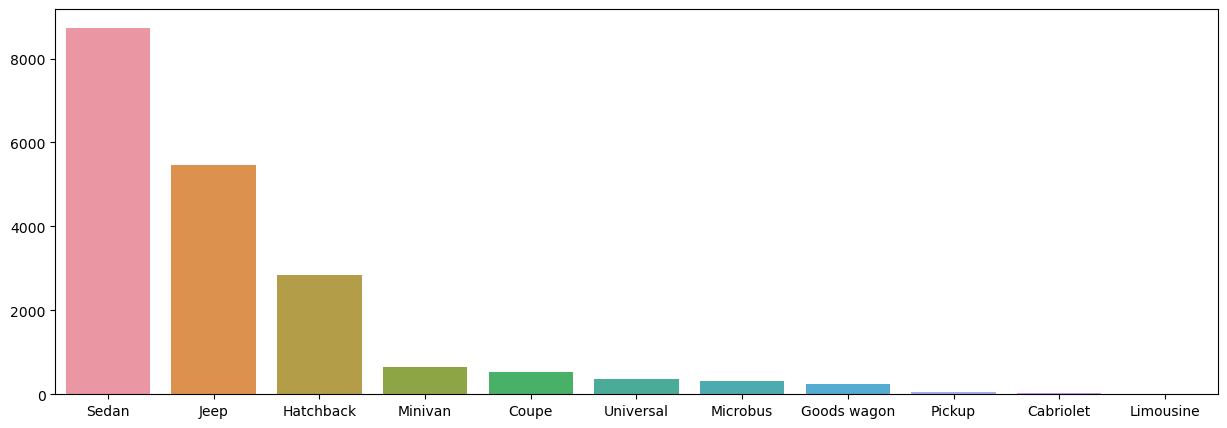

In [25]:
counts_category= df['Category'].value_counts()
plt.figure(figsize=(15,5))    
sns.barplot(counts_category.index, counts_category.values)
plt.show()

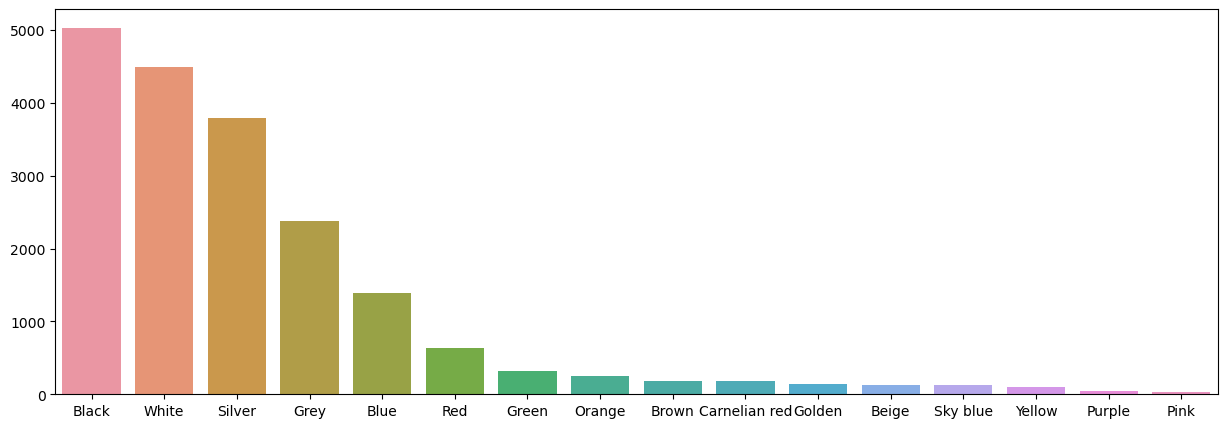

In [26]:
counts_colors = df['Color'].value_counts()
plt.figure(figsize=(15,5))    
sns.barplot(counts_colors.index, counts_colors.values)
plt.show()

**Бинарные признаки**

In [27]:
for bin_f in bin_features:
    print(bin_f)
    print(df[bin_f].value_counts())
    print('-'*75)

Leather_interior
Yes    13954
No      5283
Name: Leather_interior, dtype: int64
---------------------------------------------------------------------------
Wheel
Left wheel          17753
Right-hand drive     1484
Name: Wheel, dtype: int64
---------------------------------------------------------------------------
Turbo
False    17306
True      1931
Name: Turbo, dtype: int64
---------------------------------------------------------------------------


### Устраняем выбросы

* Cylinders

In [28]:
df[df['Cylinders'] > 12]

,ID,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Turbo
456,45773579,11604,993,OPEL,Astra,2006,Goods wagon,No,Diesel,1.3,27000,16.0,Manual,Front,04-May,Left wheel,Black,8,True
1917,45768286,7000,-,HONDA,Fit Aria,2003,Hatchback,No,Petrol,1.5,140203,16.0,Automatic,Front,04-May,Right-hand drive,Silver,2,True
6863,45802046,21953,-,HYUNDAI,Elantra,2016,Sedan,Yes,Petrol,1.8,69000,16.0,Automatic,Front,04-May,Left wheel,Silver,16,False
8358,45797531,15681,966,CHEVROLET,Lacetti,2009,Sedan,Yes,Diesel,2.0,6500,14.0,Automatic,Front,04-May,Left wheel,White,8,False
12550,45770557,39829,-,BMW,X6,2009,Jeep,Yes,Petrol,3.5,152000,16.0,Tiptronic,4x4,04-May,Left wheel,Grey,16,True
16487,45772894,7213,-,OPEL,Combo,2001,Goods wagon,No,Diesel,1.7,242701,16.0,Manual,Front,02-Mar,Left wheel,Blue,2,True


In [29]:
cylinders_mode = df['Cylinders'].mode()[0]
df.loc[df['Cylinders'] > 12, 'Cylinders'] = cylinders_mode

* Engine_volume

In [30]:
eng_volume_mean = round(df['Engine_volume'].mean(), 1)
df.loc[df['Engine_volume'] > 8, 'Engine_volume'] = eng_volume_mean
df.loc[df['Engine_volume'] == 0, 'Engine_volume'] = eng_volume_mean

* Mileage

In [31]:
mileage_lim = df['Mileage'].quantile(.996)
mileage_mean = df[df['Mileage'] < mileage_lim]['Mileage'].mean()
df.loc[df['Mileage'] > mileage_lim, 'Mileage'] = mileage_mean

* Price

In [32]:
mask = df['Price'] < 600000
df = df[mask]

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19234 entries, 0 to 19236
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19234 non-null  int64  
 1   Price             19234 non-null  int64  
 2   Levy              19234 non-null  object 
 3   Manufacturer      19234 non-null  object 
 4   Model             19234 non-null  object 
 5   Prod_year         19234 non-null  int64  
 6   Category          19234 non-null  object 
 7   Leather_interior  19234 non-null  object 
 8   Fuel_type         19234 non-null  object 
 9   Engine_volume     19234 non-null  float64
 10  Mileage           19234 non-null  float64
 11  Cylinders         19234 non-null  float64
 12  Gear_box_type     19234 non-null  object 
 13  Drive_wheels      19234 non-null  object 
 14  Doors             19234 non-null  object 
 15  Wheel             19234 non-null  object 
 16  Color             19234 non-null  object

In [34]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Turbo
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,False
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8,False
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000.0,4.0,Variator,Front,04-May,Right-hand drive,Black,2,False
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966.0,4.0,Automatic,4x4,04-May,Left wheel,White,0,False
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901.0,4.0,Automatic,Front,04-May,Left wheel,Silver,4,False


Еще раз посмотрим на выбросы

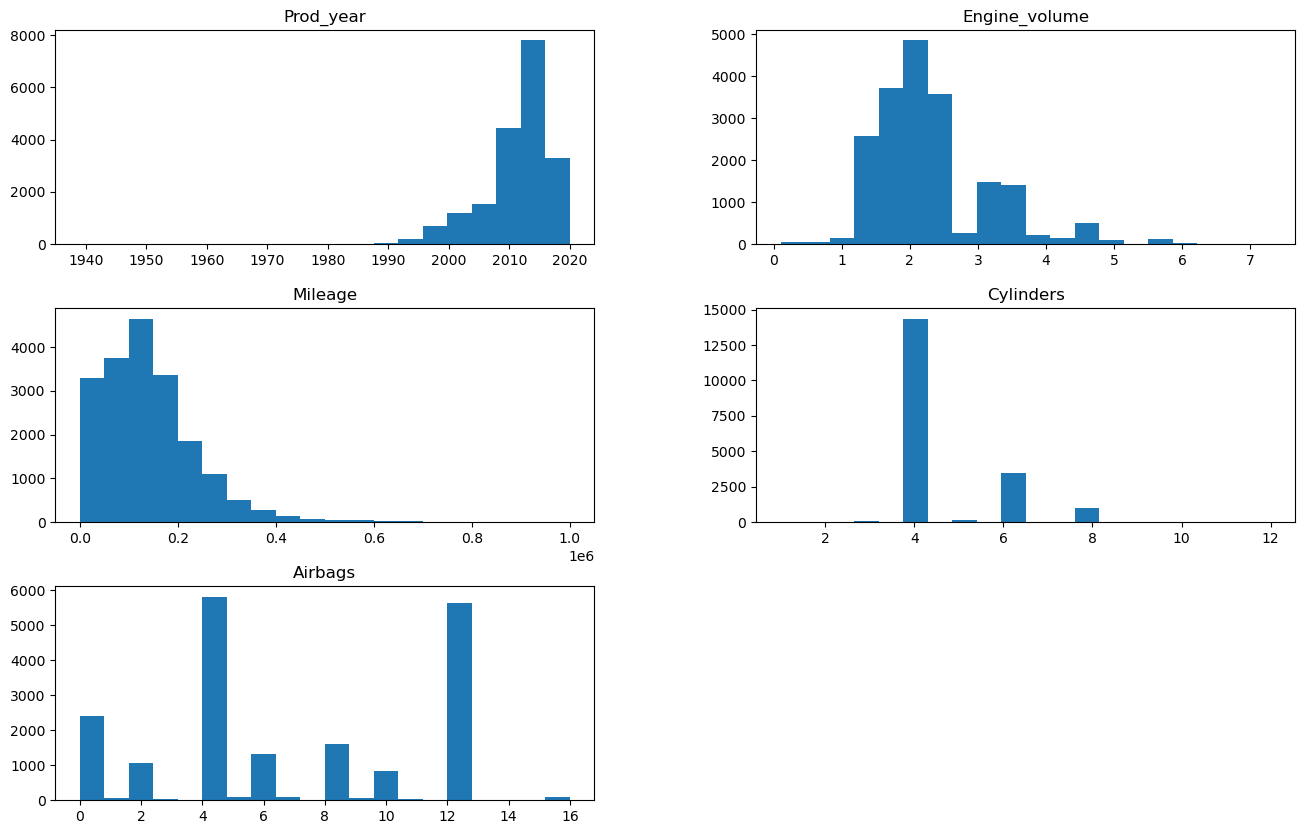

In [35]:
dftr_num_features = df[num_features]
dftr_num_features.hist(figsize=(16,10), bins=20, grid=False)
plt.show()

### Матрица корреляций

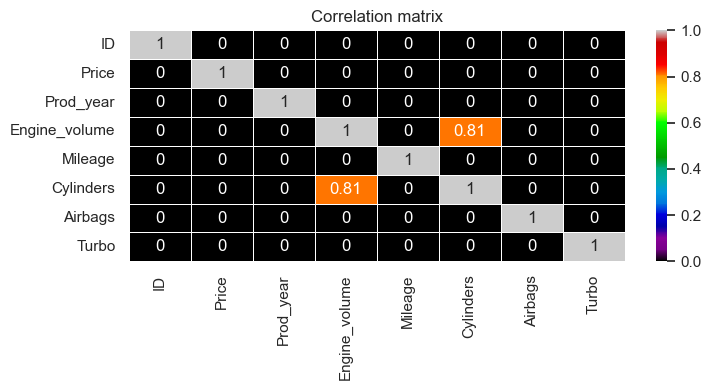

In [36]:
plt.figure(figsize = (8,3))

sns.set(font_scale=1)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='nipy_spectral')

plt.title('Correlation matrix')
plt.show()

Как видно из графика, сильно коррелируют между собой только два признака. Остальные не корреляруют вообще.

### Сохранение подготовленного датасета

In [37]:
df.to_csv(PREPARED_DATASET_PATH, index=False)

---

## 2. Моделирование <a class='anchor' id='modeling'>

### Загрузка датасета

In [38]:
df = pd.read_csv(PREPARED_DATASET_PATH)

In [39]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Turbo
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,False
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8,False
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000.0,4.0,Variator,Front,04-May,Right-hand drive,Black,2,False
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966.0,4.0,Automatic,4x4,04-May,Left wheel,White,0,False
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901.0,4.0,Automatic,Front,04-May,Left wheel,Silver,4,False


### Отбор признаков

In [40]:
continuous_columns = ['Prod_year', 'Engine_volume', 'Mileage', 'Cylinders', 'Airbags']
categorical_columns = ['Manufacturer', 'Model', "Category", 'Fuel_type', 'Gear_box_type', 'Drive_wheels', 'Doors', 'Color', 'Leather_interior', 'Wheel', 'Turbo']
target = ['Price']

### Разбиение на train и test

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df[continuous_columns+categorical_columns], 
                                                    df[target], 
                                                    random_state=12)

Сохраним

In [42]:
# train
X_train.to_csv(SPLIT_DATASET_DIR + "X_train.csv", index=None)
y_train.to_csv(SPLIT_DATASET_DIR + "y_train.csv", index=None)
# test
X_test.to_csv(SPLIT_DATASET_DIR + "X_test.csv", index=None)
y_test.to_csv(SPLIT_DATASET_DIR + "y_test.csv", index=None)

### Pipeline

In [43]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [44]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [45]:
final_transformers

[('Manufacturer',
  Pipeline(steps=[('selector', FeatureSelector(column='Manufacturer')),
                  ('ohe', OHEEncoder(key='Manufacturer'))])),
 ('Model',
  Pipeline(steps=[('selector', FeatureSelector(column='Model')),
                  ('ohe', OHEEncoder(key='Model'))])),
 ('Category',
  Pipeline(steps=[('selector', FeatureSelector(column='Category')),
                  ('ohe', OHEEncoder(key='Category'))])),
 ('Fuel_type',
  Pipeline(steps=[('selector', FeatureSelector(column='Fuel_type')),
                  ('ohe', OHEEncoder(key='Fuel_type'))])),
 ('Gear_box_type',
  Pipeline(steps=[('selector', FeatureSelector(column='Gear_box_type')),
                  ('ohe', OHEEncoder(key='Gear_box_type'))])),
 ('Drive_wheels',
  Pipeline(steps=[('selector', FeatureSelector(column='Drive_wheels')),
                  ('ohe', OHEEncoder(key='Drive_wheels'))])),
 ('Doors',
  Pipeline(steps=[('selector', FeatureSelector(column='Doors')),
                  ('ohe', OHEEncoder(key='Doors'))]

In [46]:
feats = FeatureUnion(final_transformers)

pipeline = Pipeline([
    ('features_eng', feats),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

### Обучение модели

In [47]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features_eng',
                 FeatureUnion(transformer_list=[('Manufacturer',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Manufacturer')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Manufacturer'))])),
                                                ('Model',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Model')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Model'))])),
                                                ('Category',
                                                 Pipeline(steps=[('selector',

### Сохранение модели

In [48]:
with open(MODEL_PATH, "wb") as f:
    dill.dump(pipeline, f)

---

## 3. Оценка <a class='anchor' id='evaluation'>

### Загрузка модели и датасета

In [49]:
with open(MODEL_PATH, 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [50]:
# train
X_train = pd.read_csv(SPLIT_DATASET_DIR + "X_train.csv")
y_train = pd.read_csv(SPLIT_DATASET_DIR + "y_train.csv")
# test
X_test = pd.read_csv(SPLIT_DATASET_DIR + "X_test.csv")
y_test = pd.read_csv(SPLIT_DATASET_DIR + "y_test.csv")

### Оценка качества

In [51]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """       
    """
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    print()
    print("Test MSE:\t" + str(round(mean_squared_error(test_true_values, test_pred_values), 3)))
    print("Test MAE:\t" + str(round(mean_absolute_error(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.653
Test R2:	0.582

Test MSE:	131855000.356
Test MAE:	7260.757


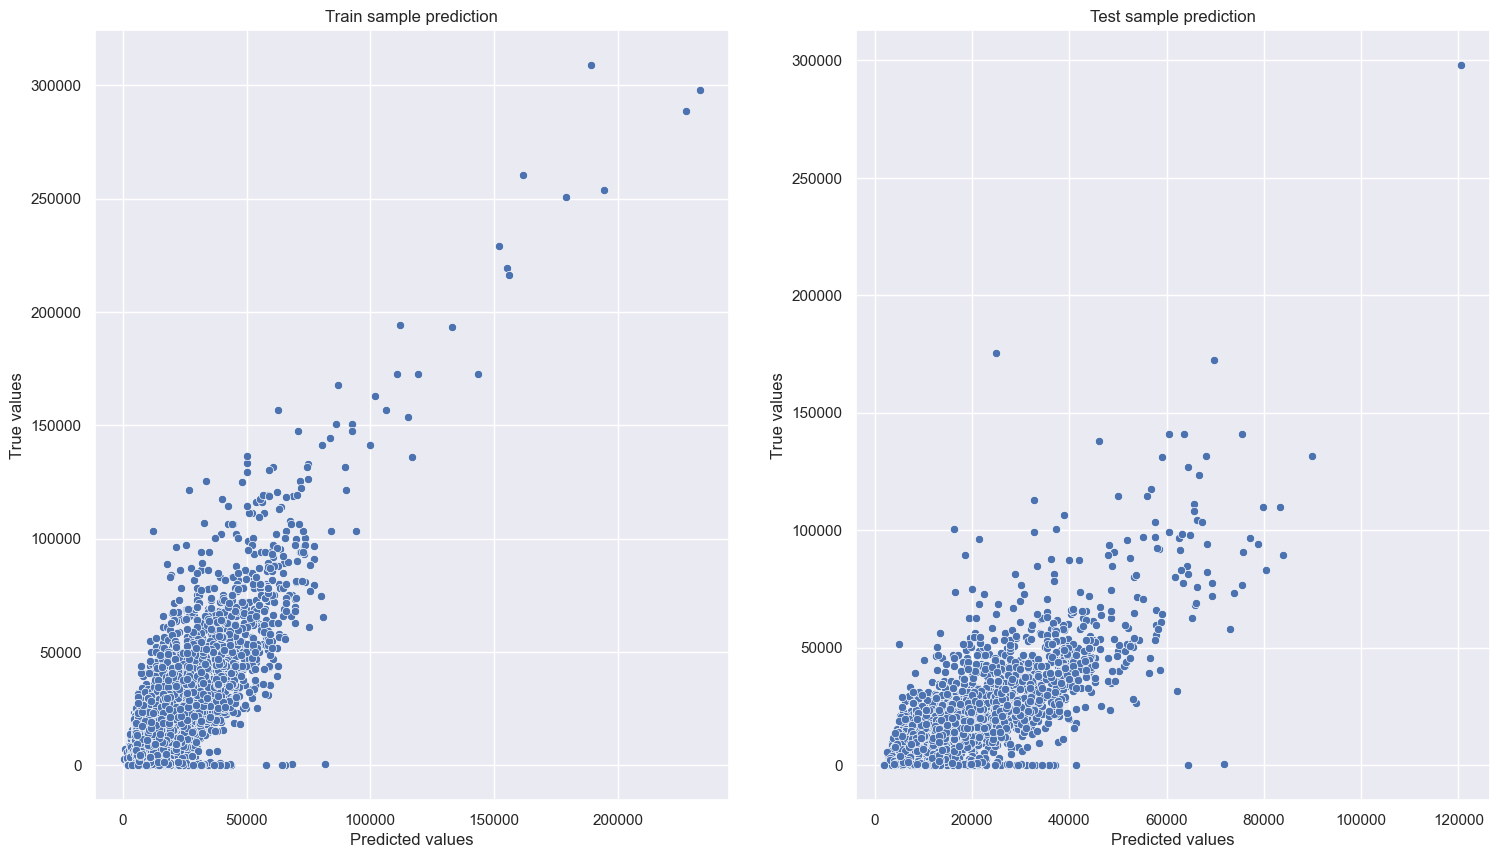

In [52]:
y_train_preds = pipeline.predict(X_train)
y_test_preds = pipeline.predict(X_test)

evaluate_preds(y_train.squeeze(), y_train_preds, y_test.squeeze(), y_test_preds)

### Сохранение предсказаний

In [53]:
y_train_preds_df = pd.DataFrame({'Train_predictions': y_train_preds})
y_test_preds_df = pd.DataFrame({'Test_predictions': y_test_preds})

y_train_preds_df.to_csv(TRAIN_PREDICTIONS_PATH, index=None)
y_test_preds_df.to_csv(TEST_PREDICTIONS_PATH, index=None)

---